# COFFEE IMAGE CLASSIFICATION
Collaborators:
- Crystal Wanjiru
- Randell Mwania
- Ian Kedeyie
- Sadi Kiri
- Simon Ng'ethe
- Victorine Imbuhila


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Overview
## Business Understanding
The project aims to address the significant threat posed by three major diseases—Coffee rust, Cercospora, and Phoma—to coffee plants in the highland areas of Kenya. These diseases have the potential to adversely impact the livelihoods of small-scale farmers who heavily depend on coffee cultivation. By implementing a technological solution for early and accurate detection of these diseases, the project seeks to empower farmers to take timely preventive measures, such as the application of fungicides, to mitigate the impact on their crops. The ultimate goal is to preserve the cultural and economic significance of coffee cultivation and contribute to the sustainability of Arabica coffee farming in the region.

## Problem Statement
The three major diseases-coffee rust, cercospora and phoma affect coffee plants and can affect the livelihoods of small-scale farmers who rely on the cultivation of coffee in the highland areas of Kenya. This project will help farmers identify these diseases at an early stage, which gives them time to take preventive measures that will reduce the impact of these diseases on their crops e.g. by using fungicides. This will give farmers a technological solution for early and accurate detection of coffee diseases. This will in turn preserve the livelihoods of the farmers, preserve the coffee culture and contribute to the sustainability of Arabica coffee cultivation.

## Objectives
Main Objective:
To develop a Convolutional Neural Network(CNN) based image classifcation model capable of accurarely distingushing between the three classes of Coffee leaf diseases.

Specific Objectives:
- To identify any patterns or anomalies in the data that may influence model performance.
- To train the mdeol using the provided dataset and evaluate its perfomance on a separate validation set.
- To explore options for deploying the trained model making it accessible for stakeholders.

# Data Understanding
The dataset contains leaf images which were collected from Arabica coffee type and it shows three sets of unhealthy images and a set of healthy images. The data obtained from [Dataset on Mendeley](https://data.mendeley.com/datasets/t2r6rszp5c/1),[Dataset on Mendeley](https://data.mendeley.com/datasets/tgv3zb82nd/1).



In [2]:

import os

# Specify the path to the main folder containing subfolders for each class
main_folder_path = '/content/drive/MyDrive/Imageclassification3/Data'

# Get a list of subfolders (each subfolder corresponds to a class)
class_folders = [folder for folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, folder))and folder != ".ipynb_checkpoints"]

# Display the number of classes
num_classes = len(class_folders)
print(f"Number of Classes: {num_classes}")
# Display the number of images in each class
for class_name in class_folders:
    class_path = os.path.join(main_folder_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of Images: {num_images}")


Number of Classes: 4
Class: Healthy, Number of Images: 8587
Class: Cerscospora, Number of Images: 6200
Class: Leafrust, Number of Images: 8315
Class: Phoma, Number of Images: 6571


The data contains 41,569 images from four different classes. One set contains images of healthy coffee leaves while the other 3 contain images of unhealthy leaves, the diseases represented are Coffee Rust, Cercospora and Phoma

## Data Preparation

In [ ]:
import cv2
import imghdr
#Getting rid of any images that are not jpeg, jpg, bmp or png
main_folder_path = '/content/drive/MyDrive/Imageclassification3/Data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(main_folder_path):
  for image in os.listdir(os.path.join(main_folder_path,image_class)):
    image_path = os.path.join(main_folder_path,image_class,image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print("Image not in ext list {}".format(image_path))
    except Exception as e:
      print('Issue with image {}'.format(image_path))


From the code above we have our images in the correct format though there is an image that is unreadable and we will go ahead and delete that one

In [7]:
 #Loads the data
import tensorflow as tf
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

data_dir = '/content/drive/MyDrive/Imageclassification3/Data'
# Set parameters
img_width, img_height = 128, 128
batch_size = 32
epochs = 5

# Create a data generator without augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load and preprocess the data for training
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')
# Load and preprocess the data for validation
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # Specify that this is the validation set

Found 25865 images belonging to 4 classes.
Found 6465 images belonging to 4 classes.


In [3]:
import tensorflow as tf

data = tf.keras.utils.image_dataset_from_directory(main_folder_path)

Found 29673 files belonging to 4 classes.


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/5
808/808 [==============================] - 4231s 5s/step - loss: 0.3519 - accuracy: 0.8611 - val_loss: 0.0116 - val_accuracy: 0.9988
Epoch 2/5
808/808 [==============================] - 769s 951ms/step - loss: 0.1170 - accuracy: 0.9563 - val_loss: 0.0135 - val_accuracy: 0.9989
Epoch 3/5
808/808 [==============================] - 773s 957ms/step - loss: 0.0711 - accuracy: 0.9740 - val_loss: 0.2134 - val_accuracy: 0.9491
Epoch 4/5
808/808 [==============================] - 788s 975ms/step - loss: 0.0284 - accuracy: 0.9898 - val_loss: 0.0262 - val_accuracy: 0.9986
Epoch 5/5
808/808 [==============================] - 777s 962ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.0232 - val_accuracy: 0.9985


In [4]:
import numpy as np
data_iterator = data.as_numpy_iterator()

In [5]:
batch = data_iterator.next()

In [6]:
batch[0].shape

(32, 256, 256, 3)

The files have been loaded into one folder that we have called data and has been reshaped to 256 by 256 pixels, batch helps as break the data down into smaller parts as our data is a lot.

In [7]:
class_names = data.class_names
print("Class Names:", class_names)


Class Names: ['Cerscospora', 'Healthy', 'Leafrust', 'Phoma']


In [8]:
label_mapping = dict(zip(class_names, range(len(class_names))))

# Print the class names and their corresponding labels
for class_name, label in label_mapping.items():
    print(f"Class Name: {class_name}, Label: {label}")

Class Name: Cerscospora, Label: 0
Class Name: Healthy, Label: 1
Class Name: Leafrust, Label: 2
Class Name: Phoma, Label: 3


The classes have been assigned the labels, Cerscospora as 0, Healthy as 1, Coffee Rust as 2 and Phoma as 3

In [9]:
#Scaling the data
data_scaled = data.map(lambda x,y: (x/255,y))

In [10]:
scaled_iterator = data_scaled.as_numpy_iterator()

In [11]:
batch_scaled = scaled_iterator.next()

#### Splitting the data into train, test and validation sets

In [12]:
train_size = int(len(data_scaled)*.7)
val_size = int(len(data_scaled)*.2)+1
test_size = int(len(data_scaled)*.1)+1

In [13]:
train = data_scaled.take(train_size)
val = data_scaled.skip(train_size).take(val_size)
test = data_scaled.skip(train_size+val_size).take(test_size)

In [34]:
from tensorflow.keras.models import load_model

model_5 = load_model('/content/drive/MyDrive/Imageclassification2/Imageclassification2/Models/model_5.h5')

In [16]:
test_loss, test_accuracy = model_2.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

93/93 [==============================] - 216s 1s/step - loss: 0.0407 - accuracy: 0.9881
Test Accuracy: 0.9881476759910583


In [17]:
y_pred_probabilities = model_2.predict(test)

# Convert predicted probabilities to class labels, it's a multiclass classification
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Now, get the true labels for the test dataset
y_true = np.concatenate([y for x, y in test], axis=0)

93/93 [==============================] - 207s 1s/step


In [18]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are your true and predicted labels

# Classification Report
class_names = ["Cerscospora", "Healthy", "Leaf Rust", "Phoma"]  # Replace with your actual class names
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

 Cerscospora       0.20      0.20      0.20       613
     Healthy       0.29      0.30      0.30       868
   Leaf Rust       0.28      0.28      0.28       819
       Phoma       0.23      0.23      0.23       653

    accuracy                           0.26      2953
   macro avg       0.25      0.25      0.25      2953
weighted avg       0.26      0.26      0.26      2953



In [38]:
model_6 = load_model('/content/drive/MyDrive/Imageclassification2/Imageclassification2/Models/LastChance.h5')

In [41]:
test_loss, test_accuracy = model_6.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy}")

203/203 [==============================] - 81s 389ms/step - loss: 0.0141 - accuracy: 0.9995
Test Accuracy: 0.9995359778404236


In [44]:
y_pred_probabilities = model_6.predict(validation_generator)

# Convert predicted probabilities to class labels, it's a multiclass classification
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Now, get the true labels for the test dataset
y_true = np.concatenate([y for x, y in validation_generator], axis=0)

203/203 [==============================] - 72s 355ms/step


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Imageclassification3/Data/Phoma/3 (1101).jpg'

In [43]:
# Classification Report
class_names = ["Cerscospora", "Healthy", "Leaf Rust", "Phoma"]  # Replace with your actual class names
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:


ValueError: Found input variables with inconsistent numbers of samples: [3210, 6465]

In [ ]:
total_samples = 32330  # Calculate the total number of samples across all classes

class_weights = {}

class_counts = {"Healthy": 8587,
                "Cerscospora": 6200,
                "Leafrust": 8315,
                "Phoma":9228}

for class_name, num_images in class_counts.items():
    class_weight = total_samples / (len(class_counts) * num_images)
    class_weights[class_name] = class_weight

print("Class Weights:", class_weights)

Class Weights: {'Healthy': 0.9412483987422848, 'Cerscospora': 1.3036290322580646, 'Leafrust': 0.9720384846662657, 'Phoma': 0.87586692674469}


In [ ]:
class_indices = {'Cerscospora': 0, 'Healthy': 1, 'Leafrust': 2, 'Phoma': 3}
class_weights = {"Cerscospora": 1.3 , "Healthy": 0.9, "Leafrust": 1,
                "Phoma": 0.9}
class_weights_indices = {class_indices[class_name]: weight for class_name, weight in class_weights.items()}

In [ ]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_5.fit(train, epochs=5, validation_data=val, class_weight=class_weights_indices)

Epoch 1/5
210/707 [=======>......................] - ETA: 31:42 - loss: 0.7625 - accuracy: 0.7869

# Exploratory Data Analysis
We are now going to view the images in our data

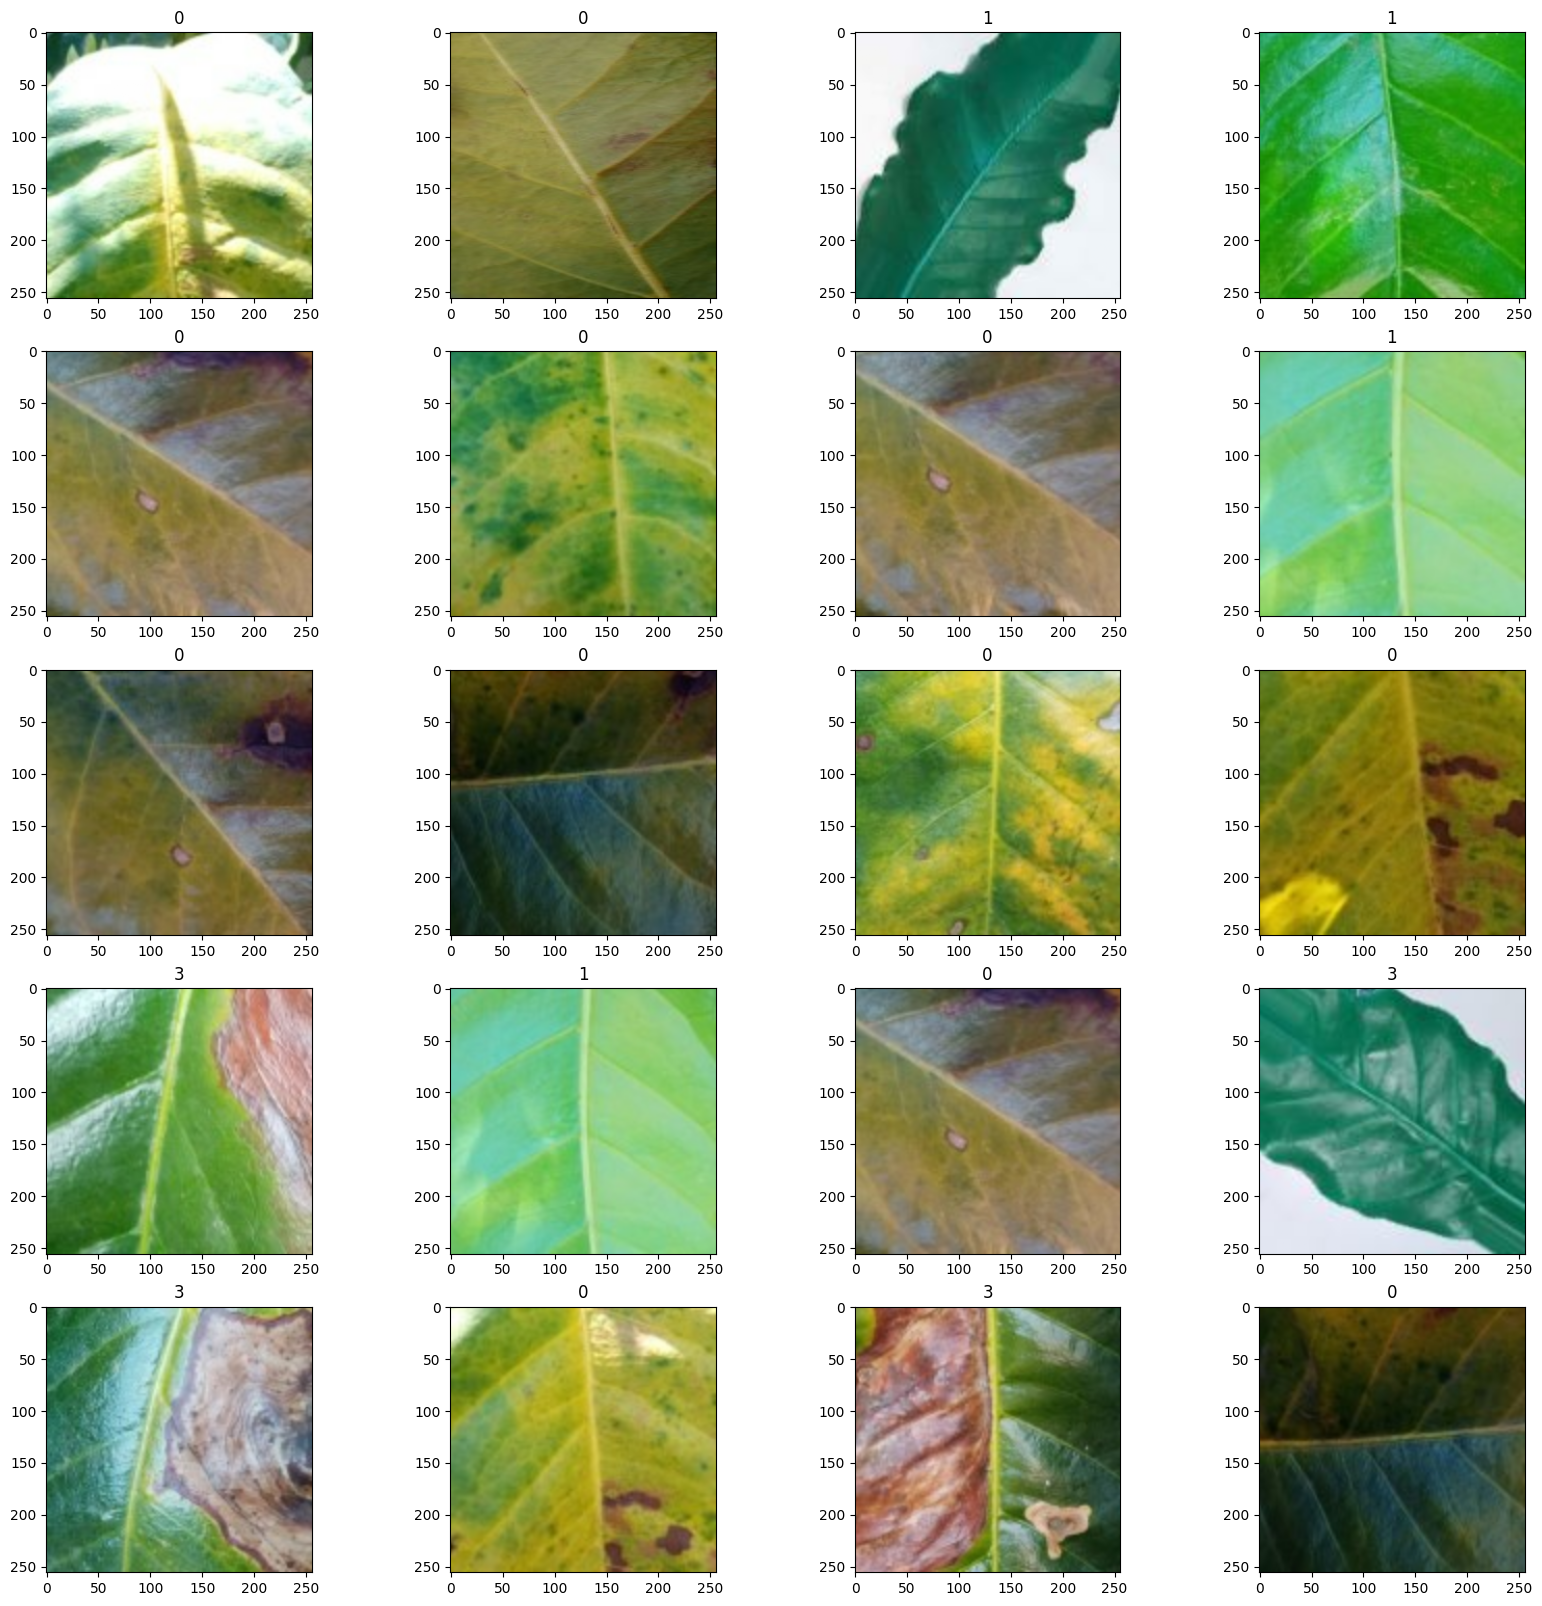

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20,20))
for i in range(5):
    for j in range(4):
        idx = i * 4 + j
        ax[i, j].imshow(batch_scaled[0][idx])
        ax[i, j].set_title(batch_scaled[1][idx])

plt.show()

From the above we can see the images with their assigned classes

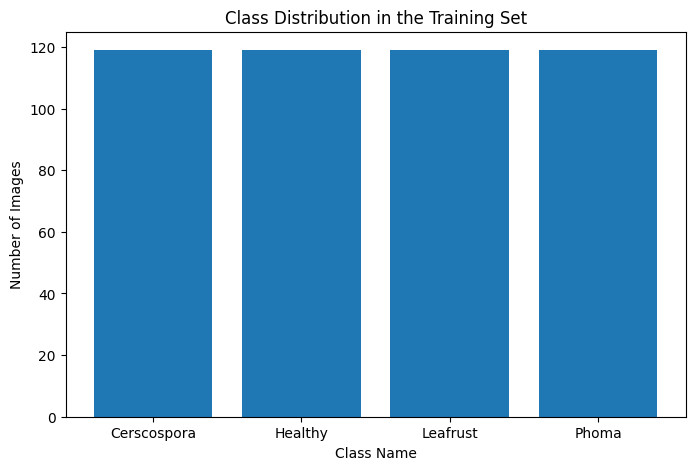

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Make sure to import numpy

# Convert EagerTensor to a NumPy array and then to a Python list
class_distribution = train.reduce(0, lambda x, _: x + 1).numpy().tolist()

# Display class distribution in the training set
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_distribution)
plt.title("Class Distribution in the Training Set")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.show()


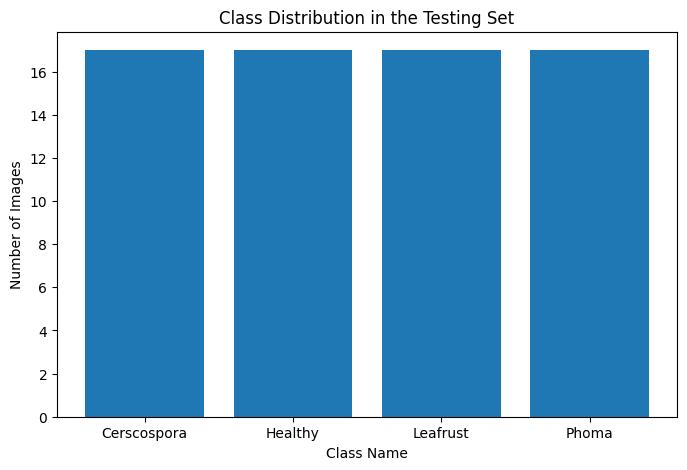

In [ ]:
# Convert EagerTensor to a NumPy array and then to a Python list
class_distribution_test = test.reduce(0, lambda x, _: x + 1).numpy().tolist()

# Display class distribution in the testing set
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_distribution_test)
plt.title("Class Distribution in the Testing Set")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
import os
import cv2

main_folder_path = "/content/drive/MyDrive/Imageclassification3/Data"
images = []
for image_class in os.listdir(main_folder_path):
    for image in os.listdir(os.path.join(main_folder_path, image_class)):
        image_path = os.path.join(main_folder_path, image_class, image)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Image {image_path} could not be loaded.")
            continue
        images.append(img)

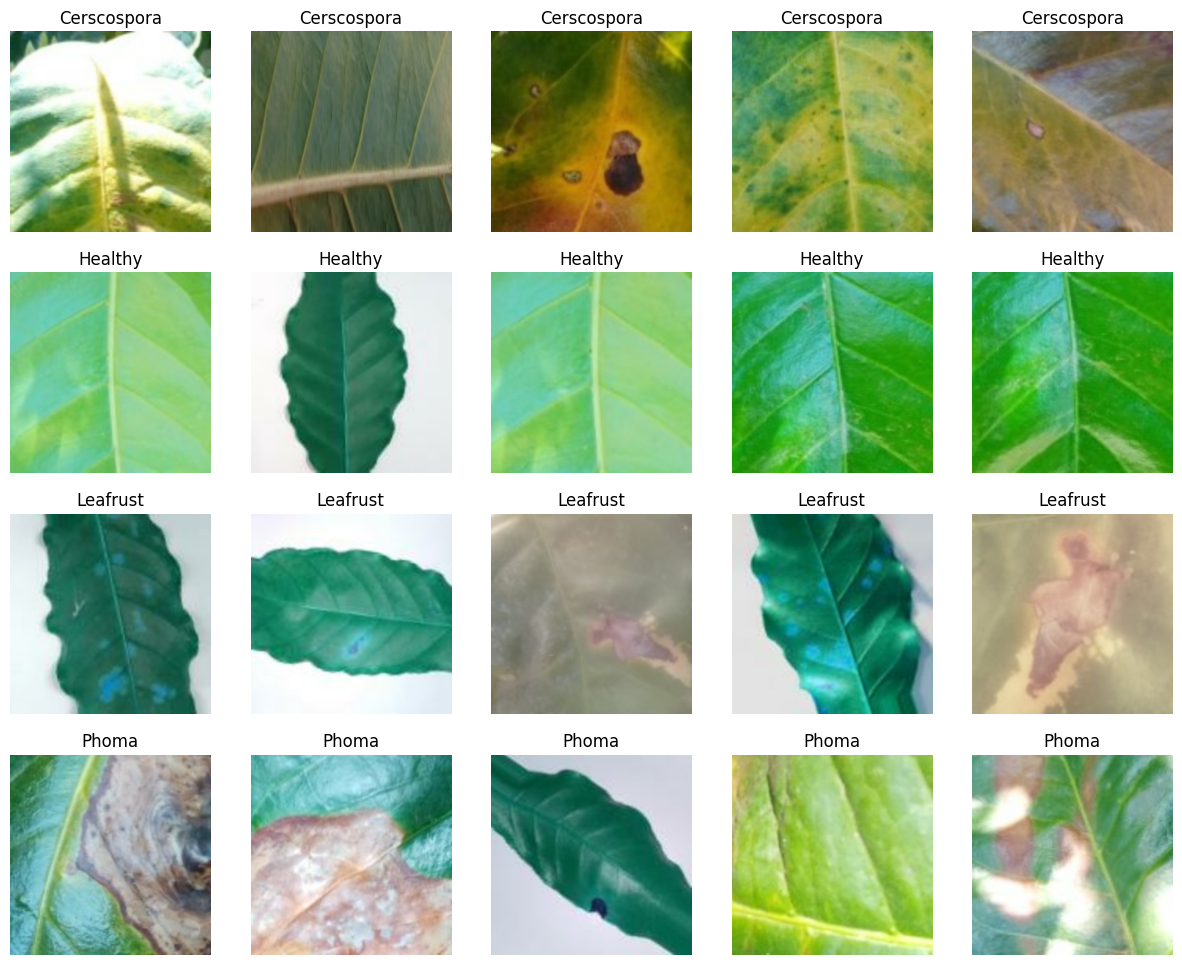

In [ ]:
images_by_class = {class_name: [] for class_name in class_names}

# Iterate through the dataset to collect five images for each class
for images, labels in data:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if len(images_by_class[class_name]) < 5:
            images_by_class[class_name].append(image.numpy())

# Plot the selected images
fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 3 * len(class_names)))
for i, class_name in enumerate(class_names):
    for j, image in enumerate(images_by_class[class_name]):
        axes[i, j].imshow(image.astype(int))
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name)

plt.show()

The above showcases 5 images from each class

In [ ]:
image_statistics_by_class = {class_name: {'mean': [], 'std': []} for class_name in class_names}

# Iterate through the dataset to calculate image statistics for each class
for images, labels in data:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        image_np = image.numpy()
        mean_values = np.mean(image_np, axis=(0, 1))
        std_values = np.std(image_np, axis=(0, 1))

        # Store statistics in the dictionary
        image_statistics_by_class[class_name]['mean'].append(mean_values)
        image_statistics_by_class[class_name]['std'].append(std_values)

# Display image statistics
for class_name, statistics in image_statistics_by_class.items():
    mean_values = np.mean(statistics['mean'], axis=0)
    std_values = np.mean(statistics['std'], axis=0)
    print(f"{class_name} - Mean values: {mean_values}, Std values: {std_values}")


Cerscospora - Mean values: [123.29145 136.95345  76.97044], Std values: [34.560966 29.786007 35.359024]
Healthy - Mean values: [101.69783 178.31505 113.37811], Std values: [43.84898  27.025305 46.23966 ]
Leafrust - Mean values: [146.56584 159.36752 141.18747], Std values: [43.02504  30.959457 32.127266]
Phoma - Mean values: [129.30467  150.88948  122.092354], Std values: [64.32406  46.301186 53.87801 ]


The above shows image statistics:
- Coffee rust: Mean values: [161.60753 159.4717  139.56525]
- Cerscospora - Mean values: [122.892944 135.90146   75.10353 ]
- Phoma - Mean values: [137.64145  145.31415  103.197296]
- Healthy - Mean values: [ 98.33829 188.19473 100.818  ]

The values represent the pixel intesity for each color channel (Red, Green,Blue) in the coffee rust images:

- Cerscospora - Std values: [34.28025  29.135378 34.75246 ]
- Healthy - Std values: [23.072763  11.9626665 34.3454   ]
- Leafrust - Std values: [23.233397 19.865278 17.498693]
- Phoma - Std values: [46.716785 39.924976 44.30034 ]

These values represent the std deviation of pixel intensities for each color channel. A higher standard deviation implies greater variability in pixel intensities.

From the above, higher mean values suggest brigher images in the corresponding color channel. e.g Coffee Rust images tend to have higher average intensities in the red channel compared to Cerscospora, Phoma and healthy leaf images.

Healthy leaves images tend to have higher average intensities in the green channel compared to Cerscospora, Phoma and healthy leaf images.


In [ ]:
total_samples = 41569  # Calculate the total number of samples across all classes

class_counts = {'Cercospora': 7681, 'Healthy': 18980, 'Leafrust': 8336, 'Phoma': 6571}
class_weights = {}

for class_name, num_images in class_counts.items():
    class_weight = total_samples / (len(class_counts) * num_images)
    class_weights[class_name] = class_weight

print("Class Weights:", class_weights)

In [ ]:
class_indices = {'Cerscospora': 0, 'Healthy': 1, 'Leafrust': 2, 'Phoma': 3}
class_weights = {"Cerscospora": 1.4 , "Healthy": 0.5, "Leafrust": 1.2,
                 "Phoma": 1.6}
class_weights_indices = {class_indices[class_name]: weight for class_name, weight in class_weights.items()}

# Use class weights during model training
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Fit the model
model_3.fit(train, epochs=5, validation_data=val, class_weight=class_weights_indices)


In [23]:
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 256, 256, 3)


In [23]:
import cv2

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))  # Adjust dimensions based on your model input shape
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img
image_path = '/content/phoma.jpg'  # Replace with your test image path
preprocessed_image = preprocess_image(image_path)

# Make predictions
predictions = model_2.predict(preprocessed_image)
class_names = data.class_names  # Replace with your actual class names

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_names[predicted_class_index]

# Display the prediction
print(f"Predicted Class: {predicted_class_label}")

1/1 [==============================] - 0s 273ms/step
Predicted Class: Phoma


In [ ]:
import numpy as np
# Oversampling the minority classes
def oversample_minority_classes(data):
    # Calculate the number of samples to add for each minority class
    class_counts = data.reduce(0, lambda x, y: x + 1).numpy()
    class_counts = np.array(class_counts)
    majority_class_count = np.max(class_counts)
    minority_class_indices = np.where(class_counts < majority_class_count)[0]
    num_samples_to_add = majority_class_count - class_counts[minority_class_indices]
# Oversample each minority class
    oversampled_data = data.map(lambda x, y: (x, y))
    for i in minority_class_indices:
        oversampled_data = oversampled_data.concatenate(
            data.filter(lambda x, y: y == i).repeat(num_samples_to_add[i])
        )

    return oversampled_data
# Combine oversampling with the existing data
oversampled_data = oversample_minority_classes(train)

# Train the model on the oversampled data
model_3.fit(oversampled_data, epochs=5, validation_data=val)

# Evaluate the model on the test set
test_loss, test_accuracy = model_3.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

In [14]:
# prompt: make a cnn baseline model and train it on the dataset

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_2.fit(train, epochs=5, validation_data=val)


Epoch 1/5
649/649 [==============================] - 2830s 4s/step - loss: 0.2742 - accuracy: 0.9100 - val_loss: 0.1011 - val_accuracy: 0.9570
Epoch 2/5
649/649 [==============================] - 2854s 4s/step - loss: 0.1215 - accuracy: 0.9516 - val_loss: 0.1011 - val_accuracy: 0.9664
Epoch 3/5
649/649 [==============================] - 2797s 4s/step - loss: 0.0809 - accuracy: 0.9655 - val_loss: 0.0963 - val_accuracy: 0.9647
Epoch 4/5
649/649 [==============================] - 2794s 4s/step - loss: 0.0721 - accuracy: 0.9737 - val_loss: 0.1818 - val_accuracy: 0.9402
Epoch 5/5
649/649 [==============================] - 2815s 4s/step - loss: 0.0435 - accuracy: 0.9835 - val_loss: 0.0600 - val_accuracy: 0.9830


In [ ]:
# prompt: create a simple model  and fit it to the data

# Define the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Fit the model
history = model_3.fit(train, epochs=5, validation_data=val)


In [ ]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes, adjust as needed

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Train the model on the dataset
model.fit(train, epochs=10, validation_data=val)  # Adjust the number

In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 256, 256, 3)


In [ ]:
from tensorflow.keras.models import load_model

# Save the trained model
model.save('/content/drive/MyDrive/Imageclassification2/Models/model_1.h5')
model_2.save('/content/drive/MyDrive/Imageclassification2/Models/model_2.h5')
model_3.save('/content/drive/MyDrive/Imageclassification2/Models/model_3.h5')

In [15]:
model_2.save('/content/drive/MyDrive/Imageclassification2/Models/model_2_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))  # Adjust dimensions based on your model input shape
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

from tensorflow.keras.models import load_model

# Load the saved model
saved_model_path = '/content/drive/MyDrive/Imageclassification2/Models/model_2.h5'  # Replace with your actual path
model = load_model(saved_model_path)
# Preprocess the image
image_path = '/content/Coffee_leaves.jpg'  # Replace with your test image path
preprocessed_image = preprocess_image(image_path)

# Make predictions
predictions = model.predict(preprocessed_image)
class_names = data.class_names  # Replace with your actual class names

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_names[predicted_class_index]

# Display the prediction
print(f"Predicted Class: {predicted_class_label}")